# Analyse des produits Norauto en lien avec du finançement Oney

**Contexte** : Ony propose du finançement aux clients Norauto à travers différents produits et sous multiples formats.
<br>
<br>
**Objectifs** : Ici, l'idée est de classer les produits selon le spectre de la rentabilité croisée Oney (Produit Net Bancaire) et Norauto (Marge via les ventes). En résumé, obtenir une matrice à 4 modalités du même type que la matrice BCG selon leur propension à être intégrés à du finançement.
<br>
<br>
Les données sont bien évidemment simulées.

## 0. Paramétrage

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import matplotlib

pd.options.display.float_format = '{:.2f}'.format

#matplotlib.use('Agg')  # For headless environments

## 1. Génération de la base de données

In [48]:
# Graine pour avoir toujours les mêmes données malgré la regénération du programme
random.seed(47)
np.random.seed(47)

# Liste de produits avec prix + catégories + usage utilitaire + marge (essentiellement récupérées à partir 
# du site norauto.fr)
produits_info = {
    "REVISION COMPLETE": {"prix": 149, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.4},
    "PNEU MICHELIN": {"prix": 79.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.25},
    "MONTAGE PNEU": {"prix": 89.99, "categorie": "Service", "utilitaire": 1, "marge_pct": 0.5},
    "BATTERIE NORAUTO": {"prix": 112.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.3},
    "HUILE MOTEUR TOTALENERGIES": {"prix": 54.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.35},
    "BALAI ESSUIE-GLACE BOSCH": {"prix": 13.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.4},
    "FILTRE A AIR NORAUTO": {"prix": 15.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.45},
    "KIT EMBRAYAGE 3 PIECES VALEO": {"prix": 149, "categorie": "Mécanique", "utilitaire": 1, "marge_pct": 0.25},
    "SERVANTE 5 TIRROIRS RACING": {"prix": 749, "categorie": "Equipement atelier", "utilitaire": 0, "marge_pct": 0.55},
    "PORTE-VELOS SUR ATTELAGE NORAUTO": {"prix": 399, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.45},
    "REMORQUE NORAUTO REGULAR": {"prix": 749, "categorie": "Mobilité", "utilitaire": 1, "marge_pct": 0.4},
    "TENTE DE TOIT BIG WILLOW": {"prix": 1590, "categorie": "Camping", "utilitaire": 0, "marge_pct": 0.6},
    "GLACIERE NORAUTO 25L": {"prix": 59.99, "categorie": "Camping", "utilitaire": 0, "marge_pct": 0.5},
    "COFFRE DE TOIT NORAUTO BERMUDE": {"prix": 1499, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.42},
    "SIEGE AUTO EVOLVEFIX": {"prix": 159, "categorie": "Mobilité", "utilitaire": 1, "marge_pct": 0.3},
    "HOUSSE PROTECTION VOITURE EXTERIEURE": {"prix": 115.99, "categorie": "Protection", "utilitaire": 0, "marge_pct": 0.55},
    "VTT ELECTRIQUE ANYWAY": {"prix": 1099, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.35},
    "VELO VILLE ELECTRIQUE EVERYWAY": {"prix": 1299, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.38},
    "CASQUE MOTO MODULABLE": {"prix": 149, "categorie": "Sécurité", "utilitaire": 1, "marge_pct": 0.32},
    "COUVRE SIEGE FLEXY": {"prix": 69.99, "categorie": "Confort", "utilitaire": 0, "marge_pct": 0.5},
    "ATTELAGE DEMONTABLE AVEC OUTIL": {"prix": 1516.99, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.42},
    "AUTORADIO SPH-DAB120": {"prix": 119.99, "categorie": "Electronique", "utilitaire": 0, "marge_pct": 0.4},
    "DASHCAM VREC 120ZRF": {"prix": 164.99, "categorie": "Electronique", "utilitaire": 0, "marge_pct": 0.45},
    "SUPPORT SMARTPHONE": {"prix": 14.99, "categorie": "Accessoire", "utilitaire": 0, "marge_pct": 0.6},
    "BOUCHON RESERVOIR CARBURANT": {"prix": 49.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.3},
    "VERIN DE COFFRE": {"prix": 26.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.3},
    "SUPPORT MURAL RABBATABLE 3 VELOS": {"prix": 49.99, "categorie": "Accessoire", "utilitaire": 0, "marge_pct": 0.43},
    "JEU COMPLET TAPIS UNIVERSELS": {"prix": 12.99, "categorie": "Confort", "utilitaire": 0, "marge_pct": 0.55},
    "LAVE GLACE TOUTES SAISONS": {"prix": 9.99, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.35},
    "POMMEAU DE LEVIER DE VITESSE": {"prix": 12.99, "categorie": "Accessoire", "utilitaire": 0, "marge_pct": 0.4},
    "NETTOYEUR MOBILE HAUTE PRESSION": {"prix": 229.99, "categorie": "Entretien", "utilitaire": 0, "marge_pct": 0.43},
    "BORNE DE RECHARGE V2C": {"prix": 1599.99, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.42},
    "CLIMATISEUR CONNECT": {"prix": 1699.99, "categorie": "Camping", "utilitaire": 0, "marge_pct": 0.42},
    "STATION ELECTRIQUE PORTABLE": {"prix": 1599.99, "categorie": "Camping", "utilitaire": 0, "marge_pct": 0.45},
    "HOUSSE PROTECTION CAMPING-CAR": {"prix": 979.99, "categorie": "Camping", "utilitaire": 0, "marge_pct": 0.44},
    "SUPPORT VELOS EN LIGNE 5 ARCEAUX": {"prix": 999.99, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.45},
    "BARRE DE TOIT": {"prix": 1099.99, "categorie": "Mobilité", "utilitaire": 1, "marge_pct": 0.47},
    "GALERIE ALUMINIUM UTILITAIRE": {"prix": 1669.99, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.43},
    "COFFRE D'ATTELAGE": {"prix": 1549.99, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.44},
    "ATTELAGE RETRACTABLE": {"prix": 199.99, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.43},
    "BATTERIE TROTINETTE MAXI EASY": {"prix": 799.99, "categorie": "Mobilité", "utilitaire": 1, "marge_pct": 0.49},
    "TROTINETTE ELECTRIQUE DRIVE": {"prix": 1599.99, "categorie": "Mobilité", "utilitaire": 0, "marge_pct": 0.43},
    "MONTAGE PNEUMATIQUE": {"prix": 95.00, "categorie": "Service", "utilitaire": 1, "marge_pct": 0.55},
    "CHANGEMENT FILTRES VEHICULE": {"prix": 40.00, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.6},
    "NETTOYAGE MOTEUR COMPLET": {"prix": 75.00, "categorie": "Service", "utilitaire": 1, "marge_pct": 0.65},
    "VIDANGE HUILE MOTEUR": {"prix": 65.00, "categorie": "Entretien", "utilitaire": 1, "marge_pct": 0.55},
    "REPARATION FREINS": {"prix": 120.00, "categorie": "Mécanique", "utilitaire": 1, "marge_pct": 0.6},
    "CONTROLE TECHNIQUE COMPLET": {"prix": 80.00, "categorie": "Service", "utilitaire": 1, "marge_pct": 0.5},
    "CHANGEMENT AMORTISSEURS": {"prix": 110.00, "categorie": "Mécanique", "utilitaire": 1, "marge_pct": 0.55},
    "REGLAGE PNEUMATIQUES": {"prix": 30.00, "categorie": "Service", "utilitaire": 1, "marge_pct": 0.5},
    "EQUILIBRAGE ROUES": {"prix": 25.00, "categorie": "Service", "utilitaire": 1, "marge_pct": 0.55}
    
    
    
}

# Périodes (début/fin)
start_date = datetime(2024, 7, 1)
end_date = datetime(2025, 6, 30)

# On limite à 200 clients
n_clients = 200
clients = []
for i in range(n_clients):
    # Avec un format d'id client du type C_9999
    client_id = f"C_{i+1:04d}"
    date_premier_achat = start_date - timedelta(days=random.randint(0, 365*3))
    clients.append({"client_id": client_id, "date_premier_achat": date_premier_achat})
clients_df = pd.DataFrame(clients)

# Tickets générés aléatoirement
tickets = []
ticket_id = 0
for _, row in clients_df.iterrows():
    client_id = row["client_id"]
    dpa = row["date_premier_achat"]
    nb_tickets = random.randint(2, 5)
    dates_tickets = sorted([start_date + timedelta(days=random.randint(0, 364)) for _ in range(nb_tickets)])
    
    for dt in dates_tickets:
        ticket_id += 1
        id_ticket = f"T_{ticket_id:05d}"
        nb_articles = np.random.choice([1, 2, 3], p=[0.6, 0.3, 0.1])
        produits_choisis = random.sample(list(produits_info.items()), nb_articles)
        
        ca_ticket = 0
        for libelle_produit, info in produits_choisis:
            montant = info["prix"]
            tickets.append({
                "id_ticket": id_ticket,
                "client_id": client_id,
                "dt_sale": dt,
                "libelle_produit": libelle_produit,
                "montant_produit": montant,
                "date_premier_achat": dpa,
                "categorie_produit": info["categorie"],
                "utilitaire": info["utilitaire"],
                "marge_estimee": montant * info["marge_pct"],
                "mois_achat": dt.month
            })
            ca_ticket += montant

        for i in range(len(tickets) - nb_articles, len(tickets)):
            tickets[i]["ca_ticket"] = round(ca_ticket, 2)
            tickets[i]["nb_articles"] = nb_articles

# Création du DataFrame principal
df = pd.DataFrame(tickets)

# Fonction qui permet de simuler le financement
# On exclut les tickets de moins de 60€ et de plus de 3500€ (cf CGU)
def assign_financement(row):
    if row["ca_ticket"] < 60 or row["ca_ticket"] > 3500:
        return "None"
    return np.random.choice(
        ["Au comptant","En 4x sans frais", "A crédit", "En 10x sans frais"],
        p=[0.40, 0.22, 0.13, 0.25]
    )

# Génération aléatoire donc parfois certains tickets sont identiques, ce qui nécessite une déduplication 
df_ticket_financement = df.drop_duplicates(subset="id_ticket").copy()

df_ticket_financement["financement"] = df_ticket_financement.apply(assign_financement, axis=1)
df = df.merge(df_ticket_financement[["id_ticket", "financement"]], on="id_ticket", how="left")

# Calcul du PNB avec des taux récupérés à partir du site Norauto
def compute_pnb(row):
    if row["financement"] == "Au comptant":
        return 0
    elif row["financement"] == "En 4x sans frais":
        return 0
    elif row["financement"] == "A crédit":
        return 0.226 * row["ca_ticket"]
    elif row["financement"] == "En 10x sans frais":
        return 0.96 * row["ca_ticket"]
    return 0

df["PNB"] = df.apply(compute_pnb, axis=1)

# Ajouts de quelques variable "techniques" afin de faciliterl'implémentation de la catégorisation ultérieure.
# Produit d'appel = produit dont le prix < 30 €
df["produit_d_appel"] = df["montant_produit"] < 30

# Variation saisonnière simulée (hiver: de 11 à 2, été: de 6 à 9)
df["variation_saisonniere"] = df["mois_achat"].apply(lambda x: "Hiver" if x in [11,12,1,2] else ("Été" if x in [6,7,8,9] else "Autre"))

# Produit multi-achat : flagger si dans un ticket avec au moins 2 articles
df["produit_multi_achat"] = df["nb_articles"] > 1

df.head(n=10)

,id_ticket,client_id,dt_sale,libelle_produit,montant_produit,date_premier_achat,categorie_produit,utilitaire,marge_estimee,mois_achat,ca_ticket,nb_articles,financement,PNB,produit_d_appel,variation_saisonniere,produit_multi_achat
0,T_00001,C_0001,2024-10-16,MONTAGE PNEUMATIQUE,95.00,2022-07-12,Service,1,52.25,10,95.00,1,A crédit,21.47,False,Autre,False
1,T_00002,C_0001,2024-11-26,COUVRE SIEGE FLEXY,69.99,2022-07-12,Confort,0,34.99,11,109.98,3,Au comptant,0.00,False,Hiver,True
2,T_00002,C_0001,2024-11-26,LAVE GLACE TOUTES SAISONS,9.99,2022-07-12,Entretien,1,3.50,11,109.98,3,Au comptant,0.00,True,Hiver,True
3,T_00002,C_0001,2024-11-26,REGLAGE PNEUMATIQUES,30.00,2022-07-12,Service,1,15.00,11,109.98,3,Au comptant,0.00,False,Hiver,True
4,T_00003,C_0001,2025-02-24,LAVE GLACE TOUTES SAISONS,9.99,2022-07-12,Entretien,1,3.50,2,1526.98,2,Au comptant,0.00,True,Hiver,True
5,T_00003,C_0001,2025-02-24,ATTELAGE DEMONTABLE AVEC OUTIL,1516.99,2022-07-12,Mobilité,0,637.14,2,1526.98,2,Au comptant,0.00,False,Hiver,True
6,T_00004,C_0002,2024-09-18,NETTOYEUR MOBILE HAUTE PRESSION,229.99,2024-02-24,Entretien,0,98.90,9,229.99,1,En 4x sans frais,0.00,False,Été,False
7,T_00005,C_0002,2025-04-24,REVISION COMPLETE,149.00,2024-02-24,Entretien,1,59.60,4,228.99,2,Au comptant,0.00,False,Autre,True
8,T_00005,C_0002,2025-04-24,PNEU MICHELIN,79.99,2024-02-24,Entretien,1,20.00,4,228.99,2,Au comptant,0.00,False,Autre,True
9,T_00006,C_0003,2024-11-09,CASQUE MOTO MODULABLE,149.00,2022-02-01,Sécurité,1,47.68,11,164.99,2,En 10x sans frais,158.39,False,Hiver,True


## 2. Segmentation des produits à travers une classification (CAH)

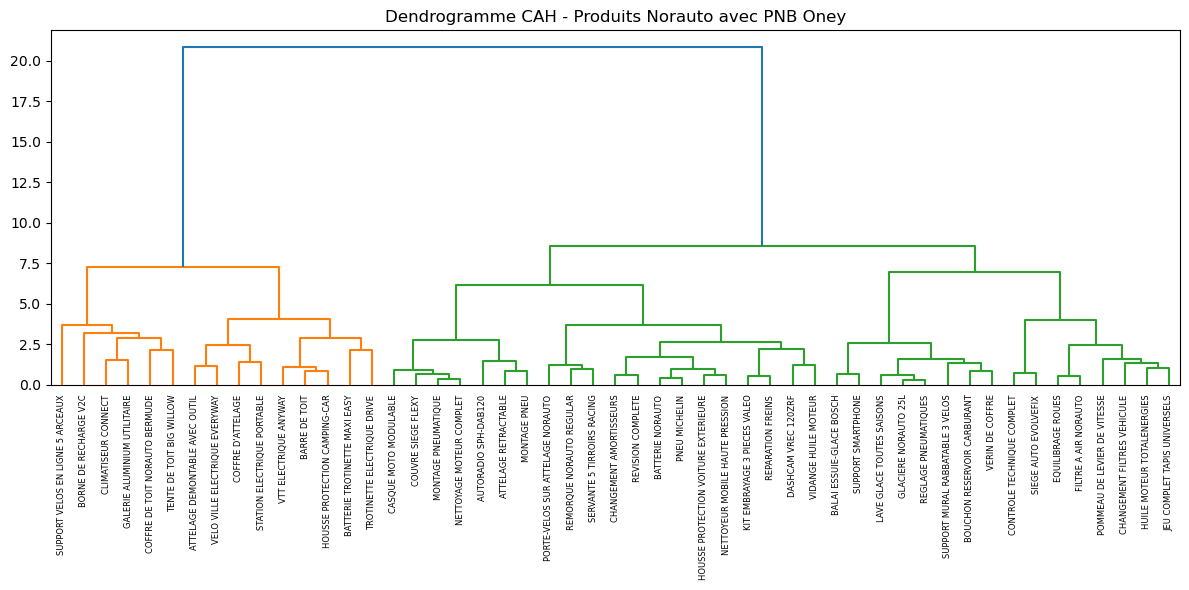

,libelle_produit,nb_tickets,montant_total,prix_moyen,nb_tickets_financement,ca_moyen_ticket,PNB_total,marge_total,utilitaire,produit_d_appel,multi_achat_ratio,categorie_produit,ratio_financement,cluster
0,ATTELAGE DEMONTABLE AVEC OUTIL,22,33373.78,1516.99,22,1917.80,14092.28,14016.99,0.00,0.00,0.50,Mobilité,1.00,2
1,ATTELAGE RETRACTABLE,34,6799.66,199.99,34,694.66,2436.80,2923.85,0.00,0.00,0.65,Mobilité,1.00,3
2,AUTORADIO SPH-DAB120,27,3239.73,119.99,27,604.61,4043.91,1295.89,0.00,0.00,0.67,Electronique,1.00,3
3,BALAI ESSUIE-GLACE BOSCH,16,223.84,13.99,8,513.17,3223.64,89.54,1.00,1.00,0.56,Entretien,0.50,4
4,BARRE DE TOIT,22,24199.78,1099.99,22,1776.98,11334.61,11373.90,1.00,0.00,0.82,Mobilité,1.00,2
5,BATTERIE NORAUTO,18,2033.82,112.99,18,619.54,4243.32,610.15,1.00,0.00,0.67,Entretien,1.00,3
6,BATTERIE TROTINETTE MAXI EASY,16,12799.84,799.99,15,1586.86,6679.35,6271.92,1.00,0.00,0.75,Mobilité,0.94,2
7,BORNE DE RECHARGE V2C,33,52799.67,1599.99,33,1888.47,19322.75,22175.86,0.00,0.00,0.48,Mobilité,1.00,1
8,BOUCHON RESERVOIR CARBURANT,20,999.80,49.99,11,420.34,2152.26,299.94,1.00,0.00,0.55,Entretien,0.55,4
9,CASQUE MOTO MODULABLE,22,3278.00,149.00,22,553.72,5623.00,1048.96,1.00,0.00,0.55,Sécurité,1.00,3


In [49]:
# Regroupement produit
df_reduit = df[['id_ticket', 'libelle_produit', 'montant_produit', 'ca_ticket', 'financement',
                'PNB', 'marge_estimee', 'categorie_produit', 'utilitaire',
                'produit_d_appel', 'variation_saisonniere', 'produit_multi_achat']].copy()
df_reduit['financé'] = df_reduit['financement'].apply(lambda x: 0 if x == "None" else 1)
df_unique = df_reduit.drop_duplicates(subset=['id_ticket', 'libelle_produit'])

# Agrégation au produit car ce sont les produits que l'on veut classifier
df_prod = df_unique.groupby('libelle_produit').agg(
    nb_tickets=('id_ticket', 'nunique'),
    montant_total=('montant_produit', 'sum'),
    prix_moyen=('montant_produit', 'mean'),
    nb_tickets_financement=('financé', 'sum'),
    ca_moyen_ticket=('ca_ticket', 'mean'),
    PNB_total=('PNB', 'sum'),
    marge_total=('marge_estimee', 'sum'),
    utilitaire=('utilitaire', 'mean'),
    produit_d_appel=('produit_d_appel', 'mean'),
    multi_achat_ratio=('produit_multi_achat', 'mean'),
    categorie_produit=('categorie_produit', lambda x: x.mode()[0] if not x.mode().empty else "Autre")
).reset_index()

# Connaître le nombre de tickets avec du financement sur le total ticket par produit.
df_prod['ratio_financement'] = df_prod['nb_tickets_financement'] / df_prod['nb_tickets']

# Normalisation & CAH
features = ['nb_tickets', 'montant_total', 'prix_moyen', 'ratio_financement',
            'ca_moyen_ticket', 'PNB_total', 'marge_total', 'multi_achat_ratio']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_prod[features])
Z = linkage(X_scaled, method='ward')
df_prod['cluster'] = fcluster(Z, t=4, criterion='maxclust')

# Dendogramme
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_prod['libelle_produit'].values, leaf_rotation=90)
plt.title("Dendrogramme CAH - Produits Norauto avec PNB Oney")
plt.tight_layout()
plt.show()

df_prod.head(n=10)

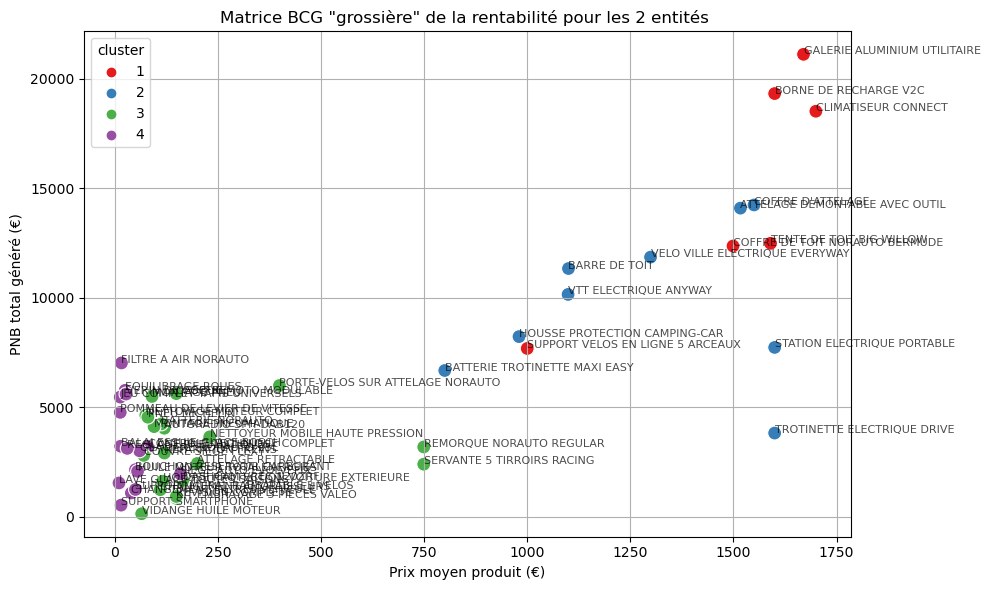

In [50]:
# Matrice type BCG : Prix moyen vs PNB total
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_prod,
    x='prix_moyen',
    y='PNB_total',
    hue='cluster',
    palette='Set1',
    s=100
)
for i in range(len(df_prod)):
    plt.text(
        df_prod['prix_moyen'][i],
        df_prod['PNB_total'][i],
        df_prod['libelle_produit'][i],
        fontsize=8,
        alpha=0.7
    )

plt.title('Matrice BCG "grossière" de la rentabilité pour les 2 entités ')
plt.xlabel('Prix moyen produit (€)')
plt.ylabel('PNB total généré (€)')
plt.grid(True)
plt.tight_layout()

In [51]:
# ListeS avec les produits concernés par cluster
clusters_produits = {}
for i in sorted(df_prod['cluster'].unique()):
    produits = df_prod[df_prod['cluster'] == i]['libelle_produit'].tolist()
    # Séparés par des virgules
    clusters_produits[f'cluster_{i}'] = ', '.join(produits)

for key, value in clusters_produits.items():
    print(f"{key} :")
    print(value)
    print("\n")
    

# Statistiques descriptives par cluster. Essayer d'avoir un profil avec les key learnings et KPIs par cluster.
stats_desc_clusters = df_prod.groupby('cluster').agg(
    nb_produits=('libelle_produit', 'count'),
    prix_moyen_cluster=('prix_moyen', 'mean'),
    ca_moyen_ticket=('ca_moyen_ticket', 'mean'),
    marge_moyenne=('marge_total', 'mean'),
    PNB_moyen=('PNB_total', 'mean'),
    taux_financement_moyen=('ratio_financement', 'mean'),
    taux_multi_achat=('multi_achat_ratio', 'mean'),
    taux_utilitaire=('utilitaire', 'mean'),
    taux_produit_d_appel=('produit_d_appel', 'mean'),
).reset_index()

# Arrondir tous les float à 2 décimales
stats_desc_clusters = stats_desc_clusters.round(2)

stats_desc_clusters.head()

cluster_1 :
BORNE DE RECHARGE V2C, CLIMATISEUR CONNECT, COFFRE DE TOIT NORAUTO BERMUDE, GALERIE ALUMINIUM UTILITAIRE, SUPPORT VELOS EN LIGNE 5 ARCEAUX, TENTE DE TOIT BIG WILLOW


cluster_2 :
ATTELAGE DEMONTABLE AVEC OUTIL, BARRE DE TOIT, BATTERIE TROTINETTE MAXI EASY, COFFRE D'ATTELAGE, HOUSSE PROTECTION CAMPING-CAR, STATION ELECTRIQUE PORTABLE, TROTINETTE ELECTRIQUE DRIVE, VELO VILLE ELECTRIQUE EVERYWAY, VTT ELECTRIQUE ANYWAY


cluster_3 :
ATTELAGE RETRACTABLE, AUTORADIO SPH-DAB120, BATTERIE NORAUTO, CASQUE MOTO MODULABLE, CHANGEMENT AMORTISSEURS, COUVRE SIEGE FLEXY, DASHCAM VREC 120ZRF, HOUSSE PROTECTION VOITURE EXTERIEURE, KIT EMBRAYAGE 3 PIECES VALEO, MONTAGE PNEU, MONTAGE PNEUMATIQUE, NETTOYAGE MOTEUR COMPLET, NETTOYEUR MOBILE HAUTE PRESSION, PNEU MICHELIN, PORTE-VELOS SUR ATTELAGE NORAUTO, REMORQUE NORAUTO REGULAR, REPARATION FREINS, REVISION COMPLETE, SERVANTE 5 TIRROIRS RACING, VIDANGE HUILE MOTEUR


cluster_4 :
BALAI ESSUIE-GLACE BOSCH, BOUCHON RESERVOIR CARBURANT, CHANGEMENT 

,cluster,nb_produits,prix_moyen_cluster,ca_moyen_ticket,marge_moyenne,PNB_moyen,taux_financement_moyen,taux_multi_achat,taux_utilitaire,taux_produit_d_appel
0,1,6,1509.83,1926.26,19781.79,15248.17,0.99,0.65,0.00,0.00
1,2,9,1282.77,1832.26,10731.86,9792.79,0.99,0.70,0.22,0.00
2,3,20,199.65,576.13,1702.62,3126.85,1.00,0.59,0.60,0.00
3,4,16,41.06,576.07,373.61,3237.08,0.61,0.64,0.69,0.50


## 3. Analyse

On s'attend à 4 modalités lors de la mise en place d'une matrice de type BCG. Le cas ici présenté serait assez proche de la réalité et fait ressortir assez nettement 3 cas de figure. Un 4ème peut malgré tout être approximé (clusters 3 & 4 assez proches). Il vient : 
<br>
<br>
* Cluster 1 : **STARS**
<br>
Prix élevé, CA élevé, marge très élevée. Donc sujets au financement.
<br>
Produits à forte valeur, très rentable, très demandés.
<br>
<br>
* Cluster 2 : **DILEMMES**
<br>
Prix élevé et CA élevé, mais marge plus faible
<br>
Assez intéressants mais moins rentables.
<br>
<br>
* Cluster 3 : **VACHES A LAIT**
<br>
Produits de gamme moyenne mais qui se vendent en masse
<br>
Marge et PNB stables. Sans plus.
<br>
<br>
* Cluster 4 : **POIDS MORTS**
<br>
Petits prix, marge et CA faibles
<br>
Beaucoup sont des produits d'appel ou peu rentables donc peu appétents à du financement.
<br>